In [ ]:
## FX Conventions ##

USDTWD = 28.53
# ccy1 foreign currency or base currency 
# ccy2 domestic currency
# ccy1ccy2 = Number of units of ccy2 required to buy ccy1. Number of units of ccy2 per ccy1

# GBPUSD = 1.6395
# Number of units of USD required to by GBP. Need 1.6395 USD to buy 1 GBP
# 1.6395 -> Read: 1 SPOT 6395. USDJPY = 92.00. -> Read : 92 figure 
# XAUDUSD = 1951.00 -> 1951 USD to buy 1 once of GOLD

In [96]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import display

In [143]:
def d12(S0,K,rd,rf,sigma,T):
    d1 = (math.log(S0/K) + (rd - rf + 0.5*sigma**2) * T)/ (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    return (d1,d2)

def d12_fwd(F0,K,sigma,T):
    d1 = (math.log(F0/K) + (0.5*sigma**2) * T)/ (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    return (d1,d2)

# theorical value of european option in basic BSM
# option to exchange K units of domestic (ccy2) for 1 unit of foreign (ccy1) expressed in domestic (ccy2)
# ccy2/ccy1 price (or domestic pips)
def option(S0,K,rd,rf,sigma,T,is_call=True):
    (d1,d2) = d12(S0,K,rd,rf,sigma,T)
    w = (-1, 1)[is_call]
    return w * S0 * math.exp(-rf*T)*norm.cdf(w*d1) - w*K*math.exp(-rd*T)*norm.cdf(w*d2)

def option_fwd(F0,K,rd,sigma,T,is_call=True):
    (d1,d2) = d12_fwd(F0,K,sigma,T)
    w = (-1, 1)[is_call]
    return w*math.exp(-rd*T)*(F0*norm.cdf(w*d1)-K*norm.cdf(w*d2))

def pips_spot_delta(F0,K,rf,sigma,T,is_call=True):
    w = (-1, 1)[is_call]
    (d1,_) = d12_fwd(F0,K,sigma,T)
    return w * math.exp(-rf*T)*norm.cdf(w*d1)

def pips_fwd_delta(F0,K,sigma,T,is_call=True):
    w = (-1, 1)[is_call]
    (d1,_) = d12_fwd(F0,K,sigma,T)
    return w *norm.cdf(w*d1)



# Quotes https://www.investing.com/currencies/eur-usd-options


EURUSD = 1.1880
fwd_1m = 7.615 / 10_000 
EURUSD_1m = EURUSD + fwd_1m
K = 1.19
notional = 1_000_000

eur_r = -0.57486 / 100
usd_r = 0.14463 / 100

# Vd/f
usd_pips = option(EURUSD,K=K,rd=usd_r,rf = eur_r,sigma=0.0705,T=30/365,is_call=True)
usd_pips_fwd = option_fwd(EURUSD_1m,K=K,rd=usd_r, sigma=0.0705,T=30/365,is_call=True)

usd_pips_market = 0.00908 # premium in USD to buy EUR at 1.19 in 1 months  
eur_pips = usd_pips / (EURUSD*K) # Vf/d = Vd/f / (spot*K)
eur_perc = usd_pips_market / EURUSD # V%f = Vd/f / spot
usd_perc = usd_pips_market / K # V%f = Vd/f / spot

# Number of units of foreign currency we need to hold in order to hedge option 
# with notional of 1 foreign currency and K domestic currency
usd_pips_spot_delta = pips_spot_delta(EURUSD_1m,K=K,rf=eur_r, sigma=0.0705,T=30/365,is_call=True)
usd_pips_fwd_delta = pips_fwd_delta(EURUSD_1m,K=K, sigma=0.0705,T=30/365,is_call=True)

# usd_pips
# usd_pips_fwd
# usd_pips_market
# eur_pips
usd_pips_spot_delta
usd_pips_fwd_delta

0.4837115544712757

0.48348306070984853

In [90]:
USDEUR = 1 / EURUSD
eur_pips = option(USDEUR,K=1/1.19,rf=usd_r,rd = eur_r,sigma=0.0704,T=30/365,is_call=False)
eur_pips

0.006324189748032172

In [165]:
import pandas as pd
eurusd_df = pd.DataFrame([['1M',0.21,0.0065,0.02433,-0.002,-0.01258],
                         ['2M',0.21,0.0075,0.0283,-0.0025,-0.01297],
                         ['3M',0.2075,0.0085,0.03228,-0.003,-0.01332],
                         ['6M',0.194,0.009,0.03485,-0.005,-0.01408],
                         ['1Y',0.1825,0.0095,0.03806,-0.006,-0.01359],
                         ['2Y',0.17677,0.0085,0.03208,-0.00562,-0.01208]], columns = ['Tenor', 'ATMVol','25dMS','10dMS','25dRR','10dRR'])

def ATM_DNS_pips(F0,sigma,T):
    return F0*math.exp(0.5*sigma**2*T)

def ATM_DNS_perc(F0,sigma,T):
    return F0*math.exp(-0.5*sigma**2*T)

def delta_to_strike(F0,delta,rf,sigma,T,is_call=True):
    w = (-1, 1)[is_call]
    return F0*math.exp(-w*norm.ppf(w*math.exp(rf*T)*delta)*sigma*math.sqrt(T)+0.5*sigma**2*T)

ATM_DNS_pips = ATM_DNS_pips(EURUSD_1m,0.0705,30/365)
# pips_spot_delta of the straddle at ATM_DNS_pips is indeed 0
DNS_delta = pips_spot_delta(EURUSD_1m,ATM_DNS_pips,eur_r,0.0705,30/365,is_call=True) + pips_spot_delta(EURUSD_1m,ATM_DNS_pips,eur_r,0.0705,30/365,is_call=False)
DNS_delta # should be 0
# ATM Vol + 25d market strangle premium in vol points
K_call_25 = delta_to_strike(1.3395,0.25,0.0346,0.1920,1,is_call=True)
K_put_25 = delta_to_strike(1.3395,-0.25,0.0346,0.1920,1,is_call=False)
K_call_25
K_put_25



-4.440892098500626e-16

1.544902905771743

1.2050195077199684

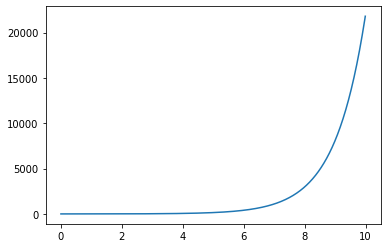

In [19]:
def f(x,T,co,c1,c2):
    return 1

x = np.arange(0,10,0.01)
F0 = 1
# y = np.sin(x)
c0 = 1
c1 = 1
c2 = 1
y = np.exp(x)
plt.plot(x,y)

In [10]:
y

array([0.        , 0.00999983, 0.01999867, 0.0299955 , 0.03998933,
       0.04997917, 0.05996401, 0.06994285, 0.07991469, 0.08987855,
       0.09983342, 0.1097783 , 0.11971221, 0.12963414, 0.13954311,
       0.14943813, 0.15931821, 0.16918235, 0.17902957, 0.18885889,
       0.19866933, 0.2084599 , 0.21822962, 0.22797752, 0.23770263,
       0.24740396, 0.25708055, 0.26673144, 0.27635565, 0.28595223,
       0.29552021, 0.30505864, 0.31456656, 0.32404303, 0.33348709,
       0.34289781, 0.35227423, 0.36161543, 0.37092047, 0.38018842,
       0.38941834, 0.39860933, 0.40776045, 0.4168708 , 0.42593947,
       0.43496553, 0.44394811, 0.45288629, 0.46177918, 0.47062589,
       0.47942554, 0.48817725, 0.49688014, 0.50553334, 0.51413599,
       0.52268723, 0.5311862 , 0.53963205, 0.54802394, 0.55636102,
       0.56464247, 0.57286746, 0.58103516, 0.58914476, 0.59719544,
       0.60518641, 0.61311685, 0.62098599, 0.62879302, 0.63653718,
       0.64421769, 0.65183377, 0.65938467, 0.66686964, 0.67428

In [ ]:
plot(x,y)